In [4]:
import nltk
import numpy as np
from scipy.stats import pearsonr
import sim_cal
import matplotlib.pyplot as plt

In [ ]:
path='D:/misc/Projects/Python/NLP/misc'
nltk.data.path.append(path)
nltk.download('averaged_perceptron_tagger_eng',download_dir=path)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     D:/misc/Projects/Python/NLP/misc...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


True

In [2]:
with open('msr_paraphrase_corpus.txt','r') as f:
    t=f.readlines()[1:]
for i in range(len(t)):
    split=t[i].split('\t')
    t[i]=[int(split[0]),split[3],split[4].strip('\n')]

## 1)

In [ ]:
def evaluate(pair,num=0):
    split=pair.copy()
    return [split[0],sim_cal.Similarity(split[1],split[2],num)]
evaluate(t[1])

[0, 0.54]

In [ ]:
simscores=list(map(evaluate,t))

In [ ]:
npsims=np.array(simscores)
pearsonr(npsims[:,0],npsims[:,1])

PearsonRResult(statistic=0.2605666859715297, pvalue=3.015849315732531e-64)

In [ ]:
simscores_res=list(map(lambda x: evaluate(x,1),t))

In [ ]:
npsims_res=np.array(simscores_res)
pearsonr(npsims_res[:,0],npsims_res[:,1])

PearsonRResult(statistic=0.08305904725115089, pvalue=1.0942322511152532e-07)

In [ ]:
npsims_res[:,1]

array([2.37940432e+299, 2.43415746e+299, 4.59816563e+299, ...,
       2.64647924e+299, 4.52000000e+000, 4.22754553e+299])

## 2)

In [ ]:
import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
from nltk.metrics import edit_distance
import numpy as np

def leacock_chodorow_similarity(word1, word2):
    # Get the synsets for each word
    synsets1 = wn.synsets(word1)
    synsets2 = wn.synsets(word2)

    # Initialize an empty list to store the path lengths
    path_lengths = []

    # Calculate the path length for each pair of synsets
    for synset1 in synsets1:
        for synset2 in synsets2:
            path_length = synset1.shortest_path_distance(synset2)
            if path_length is not None:
                path_lengths.append(path_length)

    # Calculate the shortest path length
    if len(path_lengths) > 0:
        shortest_path_length = min(path_lengths)
    else:
        shortest_path_length = np.inf

    # Calculate the length of the longest common subsequence
    lcs_length = edit_distance(word1, word2)

    # Calculate the similarity score
    if shortest_path_length==0:
        similarity_score=1
    elif shortest_path_length==np.inf:
        similarity_score=0
    else:
        similarity_score = -np.log(lcs_length / (2 * shortest_path_length))


    return similarity_score

def word_similarity(w1, w2, num):
    """Calculate similarity between two words only if they share the same POS."""
    pos1 = sim_cal.get_wordnet_pos(w1)
    pos2 = sim_cal.get_wordnet_pos(w2)

    try:
        similarity = leacock_chodorow_similarity(w1, w2)
        if similarity:
            return round(similarity, 2)
    except nltk.corpus.reader.wordnet.WordNetError:
        return 0
    return 0

def Similarity(T1, T2, num=0):
    """Calculate sentence-to-sentence similarity using TF-IDF and WordNet similarity."""
    words1 = sim_cal.preProcess(T1)
    words2 = sim_cal.preProcess(T2)

    tf = sim_cal.TfidfVectorizer(use_idf=True)
    tf.fit_transform([' '.join(words1), ' '.join(words2)])

    Idf = dict(zip(tf.get_feature_names_out(), tf.idf_))

    Sim_score1 = 0
    Sim_score2 = 0

    for w1 in words1:
        Max = 0
        for w2 in words2:
            score = word_similarity(w1, w2, num)
            if Max < score:
                Max = score
        Sim_score1 += Max * Idf.get(w1, 0)
    Sim_score1 /= sum([Idf.get(w1, 0) for w1 in words1])

    for w2 in words2:
        Max = 0
        for w1 in words1:
            score = word_similarity(w1, w2, num)
            if Max < score:
                Max = score
        Sim_score2 += Max * Idf.get(w2, 0)
    Sim_score2 /= sum([Idf.get(w2, 0) for w2 in words2])

    Sim = (Sim_score1 + Sim_score2) / 2

    return round(Sim, 2)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\emanu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def cust_evaluate(pair):
    split=pair.copy()
    return [split[0],Similarity(split[1],split[2])]

In [ ]:
simscores_lcs=list(map(lambda x: cust_evaluate(x),t))

In [ ]:
npsims_lcs=np.array(simscores_lcs)
pearsonr(npsims_lcs[:,0],npsims_lcs[:,1])

PearsonRResult(statistic=0.10856297111917781, pvalue=3.666655311794204e-12)

In [ ]:
from pandas import DataFrame

df=DataFrame({'Label': npsims[:,0],'wup': npsims[:,1],'lcs': npsims_lcs[:,1]})
df

,Label,wup,lcs
0,1.0,0.75,0.72
1,0.0,0.54,0.93
2,1.0,0.69,1.33
3,0.0,0.72,1.24
4,1.0,0.72,1.32
...,...,...,...
4071,1.0,0.47,1.02
4072,0.0,0.61,1.11
4073,1.0,0.74,1.18
4074,1.0,0.57,1.12


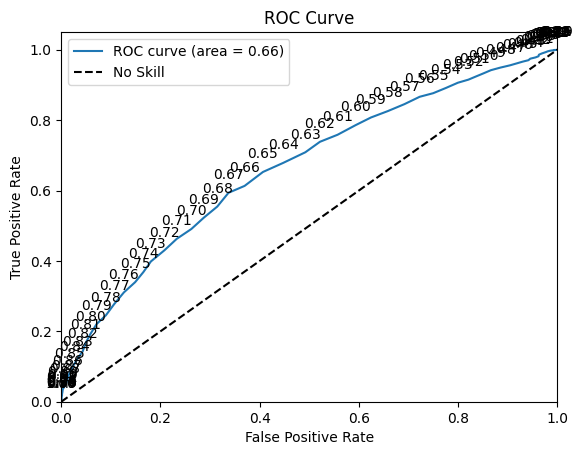

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

quality = npsims[:,0]
proba  = npsims[:,1]

fpr, tpr, thresholds = roc_curve(quality, proba)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curve')
for i, threshold in enumerate(thresholds):
    plt.annotate(f'{threshold:.2f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.legend()
plt.show()

## We can choose value 0.66

In [ ]:
#calculate accuracy using that threshold
threshold=0.66
wuplabels=npsims[:,1]
wuplabels=wuplabels>0.66
f'{np.sum(wuplabels==npsims[:,0])/npsims[:,0].size} accuracy'

'0.616045142296369 accuracy'

## 4)

In [ ]:
import pandas as pd

df = pd.read_csv('msr_paraphrase_corpus.txt', delimiter='\t', usecols=[0, 1, 2, 3, 4])
incorrect_matches = df[df['Quality'] == 0]
incorrect_matches.head()
print("Length of incorrect matches: ", len(incorrect_matches))
# Define a list of words quantifiers such as negation
quantifiers = ['not', 'no', 'never', 'none', 'nobody', 'nothing', 'neither', 'nowhere', 'hardly', 'scarcely', 'barely']

# Join the list into a single string pattern
pattern = '|'.join(quantifiers)

mask = incorrect_matches['String1'].str.contains(pattern, case=False, na=False) | incorrect_matches['String2'].str.contains(pattern, case=False, na=False)

# Filter the DataFrame
result_df = incorrect_matches[mask]
result_df.head()


Length of incorrect matches:  1285


,Quality,ID1,ID2,String1,String2
8,0,3114205,3114194,"That compared with $35.18 million, or 24 cents...",Earnings were affected by a non-recurring $8 m...
19,0,1713015,1712982,A BMI of 25 or above is considered overweight;...,A BMI between 18.5 and 24.9 is considered norm...
28,0,1783137,1782659,No dates have been set for the civil or the cr...,No dates have been set for the criminal or civ...
56,0,2506257,2506206,The women then had follow-up examinations afte...,The women had follow-up examinations in 1974-7...
60,0,2277501,2277502,"American Masters: Arthur Miller, Elia Kazan an...",Note the subheading of this terrible parable i...


In [ ]:
print("Length of incorrect matches with quantifiers: ", len(result_df))
percentage = round(len(result_df) / len(incorrect_matches) * 100, 2)
print(f"Percentage of incorrect matches with quantifiers: {percentage}%")

Length of incorrect matches with quantifiers:  408
Percentage of incorrect matches with quantifiers: 31.75%


## 5)

In [11]:
#word2vec similarity
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import gensim.downloader as api
from gensim.models import KeyedVectors

path = api.load("word2vec-google-news-300", return_path=True)
print(path)

# Load the word2vec model
w2vmodel = KeyedVectors.load_word2vec_format(path, binary=True)
glove_model = api.load("glove-wiki-gigaword-300")


def sentence_to_vector(sentence, model):
    words = sentence.split()
    word_vectors = [model[word] for word in words if word in model]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

def sentence_similarity(split, model):
    sentence1=split[1]
    sentence2=split[2]
    vec1 = sentence_to_vector(sentence1, model)
    vec2 = sentence_to_vector(sentence2, model)
    return [int(split[0]),cosine_similarity([vec1], [vec2])[0][0]]


/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [12]:
#calculate for word2vec
simscores_w2v=list(map(lambda x: sentence_similarity(x,w2vmodel),t))

In [13]:
npsims_w2v=np.array(simscores_w2v)
print(pearsonr(npsims_w2v[:,0],npsims_w2v[:,1]),' for word2vec')

PearsonRResult(statistic=0.3318047249650135, pvalue=2.447895319223956e-105)  for word2vec


In [14]:
simscores_gl=list(map(lambda x: sentence_similarity(x,glove_model),t))

In [15]:
npsims_gl=np.array(simscores_gl)
print(pearsonr(npsims_gl[:,0],npsims_gl[:,1]),' for glove')

PearsonRResult(statistic=0.2952968985773041, pvalue=8.136667632370158e-83)  for glove


## In order to respect the deadline, we did not use fasttext because it was taking too long to download. However, the procedure is the same as what we have already done with the other models

In [ ]:
# Fasttext model for fasttext similarity
import fasttext
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

import fasttext.util

# Load pre-trained FastText vectors
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

def sentence_embedding(sentence, model):
    words = sentence.split()
    word_embeddings = [model.get_word_vector(word) for word in words]
    return np.mean(word_embeddings, axis=0)

# Calculate the embedding for each sentence
embedding_T1 = sentence_embedding("frase 1", ft)
embedding_T2 = sentence_embedding("frase 2", ft)

# Compute the cosine similarity between the two sentence embeddings
similarity = cosine_similarity([embedding_T1], [embedding_T2])
print("Fasttext similarity score:", similarity[0][0])

def fast_text_sim(split):
    embedding_T1 = sentence_embedding(split[1], ft)
    embedding_T2 = sentence_embedding(split[2], ft)
    return [int(split[0]),cosine_similarity([embedding_T1],embedding_T2)]

In [ ]:
simscores_ft=list(map(lambda x: fast_text_sim(x),t))

In [ ]:
npsims_ft=np.array(simscores_ft)
print(pearsonr(npsims_ft[:,0],npsims_ft[:,1]),' for fasttext')

## 6)

In [6]:
from fuzzywuzzy import fuzz
from nltk.stem import WordNetLemmatizer

def sentence_similarity(split):
    sentence1,sentence2=split[1:]
    return [int(split[0]),fuzz.ratio(sentence1, sentence2)]

In [7]:
simscores_fw=list(map(lambda x: sentence_similarity(x),t))

In [9]:
npsims_fw=np.array(simscores_fw)
print(pearsonr(npsims_fw[:,0],npsims_fw[:,1]), ' for fuzzywuzzy')

PearsonRResult(statistic=0.387412117540374, pvalue=4.392708118146467e-146)  for fuzzywuzzy


In [16]:
from pandas import DataFrame

df=DataFrame({'Label': npsims_w2v[:,0],'word2vec': npsims_w2v[:,1],'glove':npsims_gl[:,1],'fuzzywuzzy': npsims_fw[:,1]})
df

,Label,word2vec,glove,fuzzywuzzy
0,1.0,0.947899,0.962642,65
1,0.0,0.771061,0.909631,63
2,1.0,0.891396,0.962313,70
3,0.0,0.844657,0.948088,62
4,1.0,0.838936,0.936992,61
...,...,...,...,...
4071,1.0,0.835489,0.951334,65
4072,0.0,0.822037,0.944030,66
4073,1.0,0.925762,0.971995,80
4074,1.0,0.582961,0.833310,47


In [12]:
cat_embeddings=[np.random.normal(size=(100,500), loc=i*5) for i in range(6)]
tweet_emoticons=range(6)

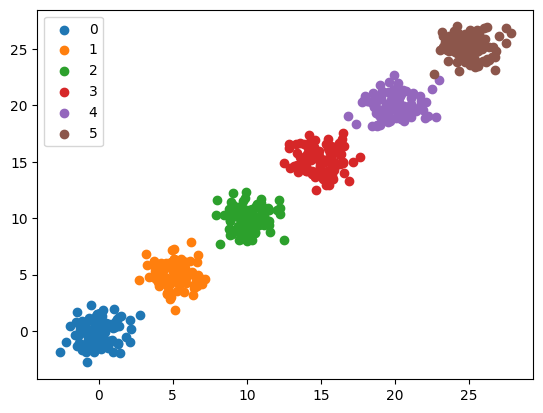

In [13]:
colors=['g','b','r','y','c','m']
[plt.scatter(cat_embeddings[i][:,0],cat_embeddings[i][:,1], label=tweet_emoticons[i]) for i in range(len(cat_embeddings))]
plt.legend()
plt.show()